# Environtment Setup

In [ ]:
!pip install tensorflow==2.15.0
!pip install tf_keras==2.15.0

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras. __version__)

TensorFlow version:  2.15.0
Keras version:  2.15.0


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import shutil
import random
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# Dataset Preparation

In [ ]:
# Download Dataset from kaggle using API key
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexandroaurellino
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf


100%|██████████| 179M/179M [00:01<00:00, 127MB/s]


In [ ]:
# Define the dataset paths
train_dir = '/content/tomatoleaf/tomato/train'
val_dir = '/content/tomatoleaf/tomato/val'
test_dir = "/content/tomatoleaf/tomato/test"

In [ ]:
# Create the test directory if it doesn't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create subdirectories and copy images
for class_name in os.listdir(val_dir):
    class_val_path = os.path.join(val_dir, class_name)
    class_test_path = os.path.join(test_dir, class_name)

    # Create subdirectory for each class in the test folder
    if not os.path.exists(class_test_path):
        os.makedirs(class_test_path)

    # Get all images in the validation class folder
    images = [f for f in os.listdir(class_val_path) if os.path.isfile(os.path.join(class_val_path, f))]

    # Randomly select 10 images
    selected_images = random.sample(images, min(10, len(images)))

    # Copy selected images to the test directory
    for image in selected_images:
        src_path = os.path.join(class_val_path, image)
        dest_path = os.path.join(class_test_path, image)
        shutil.copy(src_path, dest_path)

print("Test dataset created successfully!")

Test dataset created successfully!


In [ ]:
# Get the class labels from the training directory
train_class_labels = os.listdir(train_dir)

# Function to sync class folders
def sync_class_folders(source_dir, target_dir, class_labels):
    for label in class_labels:
        source_class_path = os.path.join(source_dir, label)
        target_class_path = os.path.join(target_dir, label)

        # Create the class folder in the target directory if it doesn't exist
        if not os.path.exists(target_class_path):
            os.makedirs(target_class_path)

# Sync class folders for validation and test directories
sync_class_folders(train_dir, val_dir, train_class_labels)
sync_class_folders(train_dir, test_dir, train_class_labels)

print("Class folders synced successfully!")

Class folders synced successfully!


In [26]:
# Get the class labels
class_labels = os.listdir(train_dir)

# Function to print total images for each label in a directory
def print_image_counts(data_dir, class_labels):
    print(f"Image counts for directory: {data_dir}")
    for label in class_labels:
        class_path = os.path.join(data_dir, label)
        num_images = len(os.listdir(class_path))
        print(f"{label:50}: {num_images} images")
    print("\n")

# Print image counts for train, validation, and test directories
print_image_counts(train_dir, class_labels)
print_image_counts(val_dir, class_labels)
print_image_counts(test_dir, class_labels)

Image counts for directory: /content/tomatoleaf/tomato/train
Tomato___Target_Spot                              : 1000 images
Tomato___Bacterial_spot                           : 1000 images
Tomato___Early_blight                             : 1000 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus            : 1000 images
Tomato___Septoria_leaf_spot                       : 1000 images
Tomato___healthy                                  : 1000 images
Tomato___Tomato_mosaic_virus                      : 1000 images
Tomato___Spider_mites Two-spotted_spider_mite     : 1000 images
Tomato___Leaf_Mold                                : 1000 images
Tomato___Late_blight                              : 1000 images


Image counts for directory: /content/tomatoleaf/tomato/val
Tomato___Target_Spot                              : 100 images
Tomato___Bacterial_spot                           : 100 images
Tomato___Early_blight                             : 100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus           

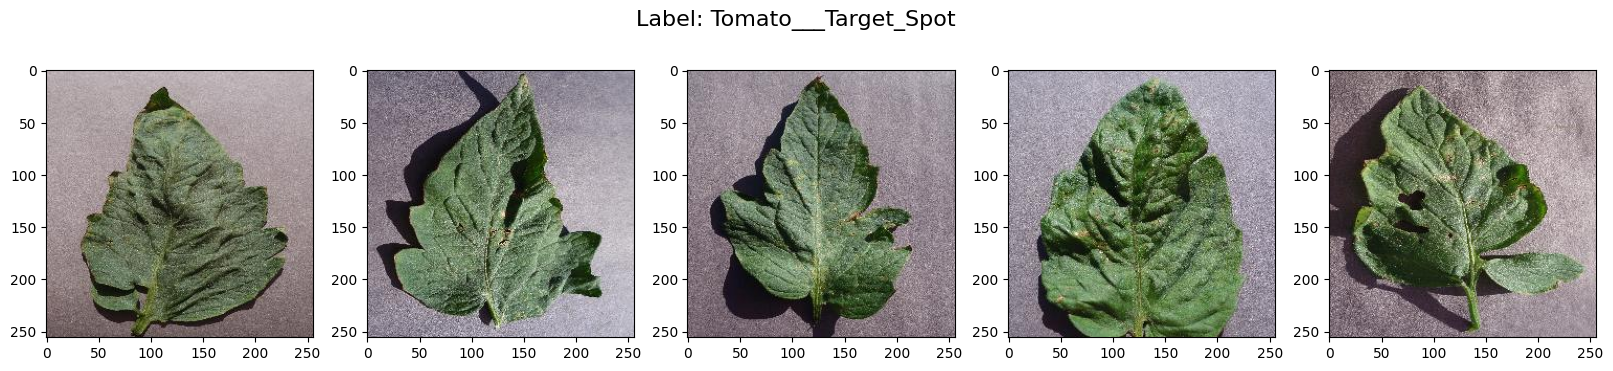

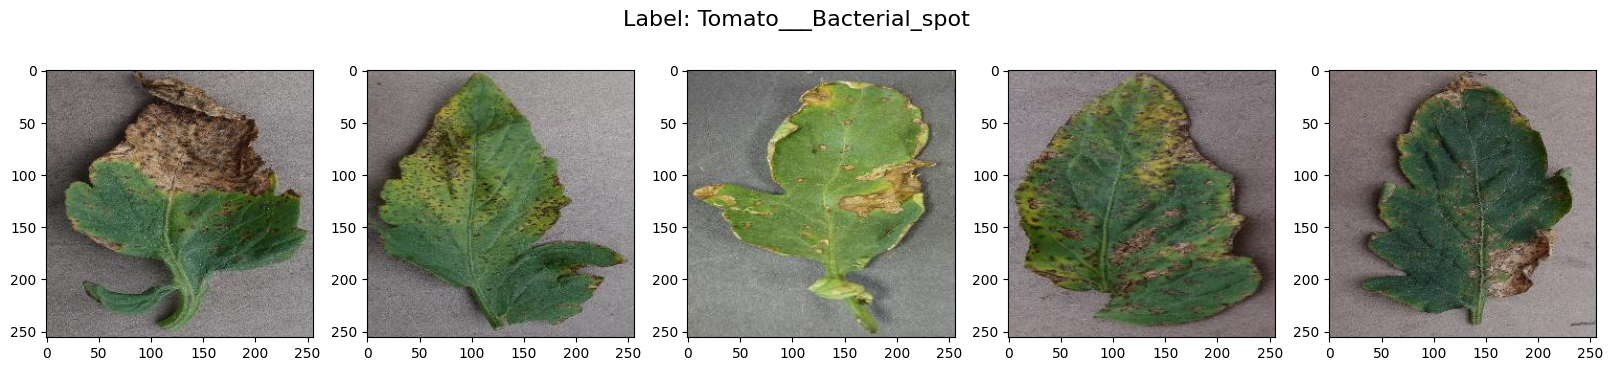

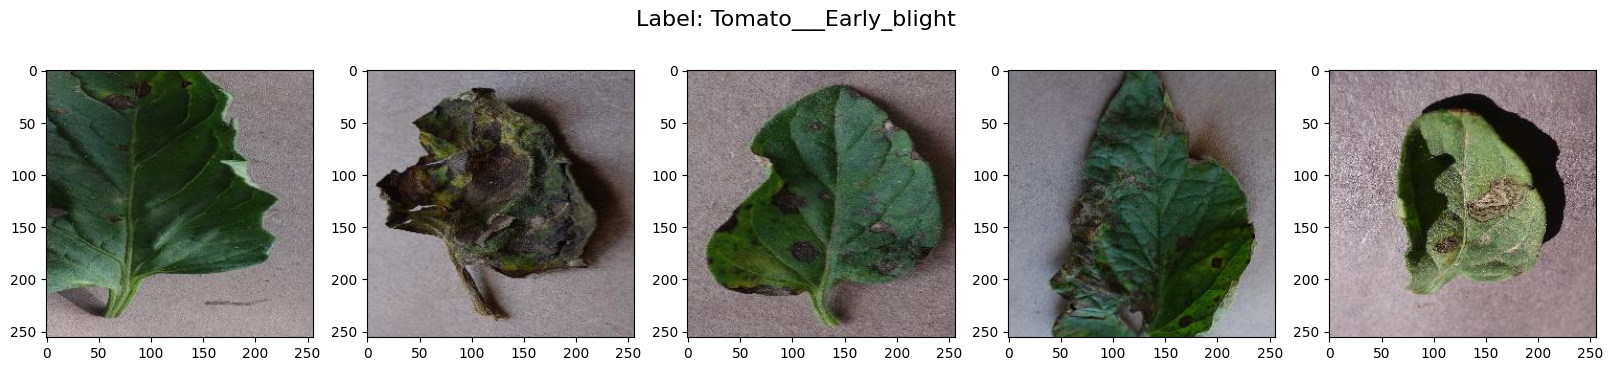

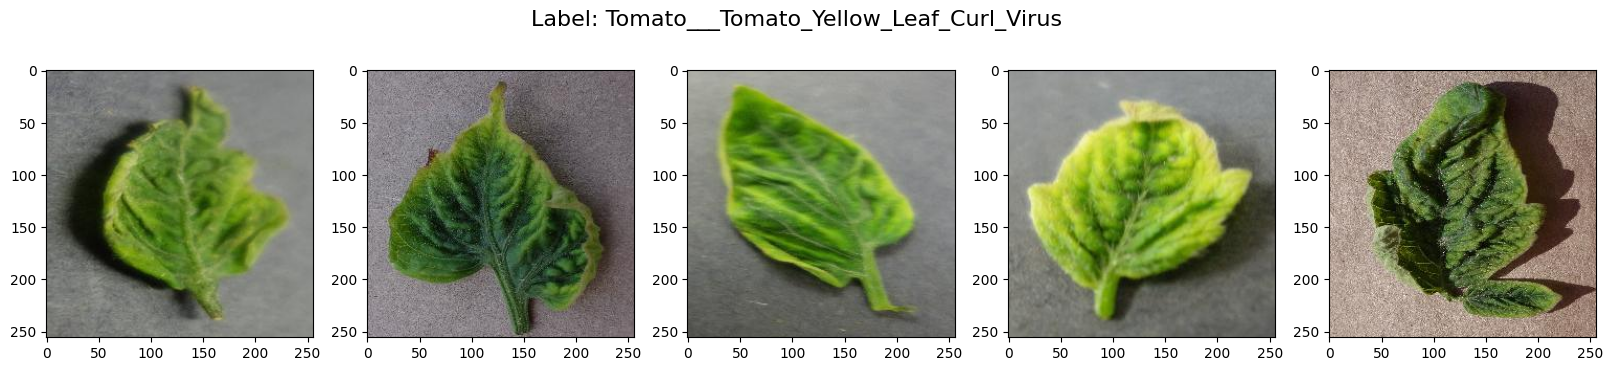

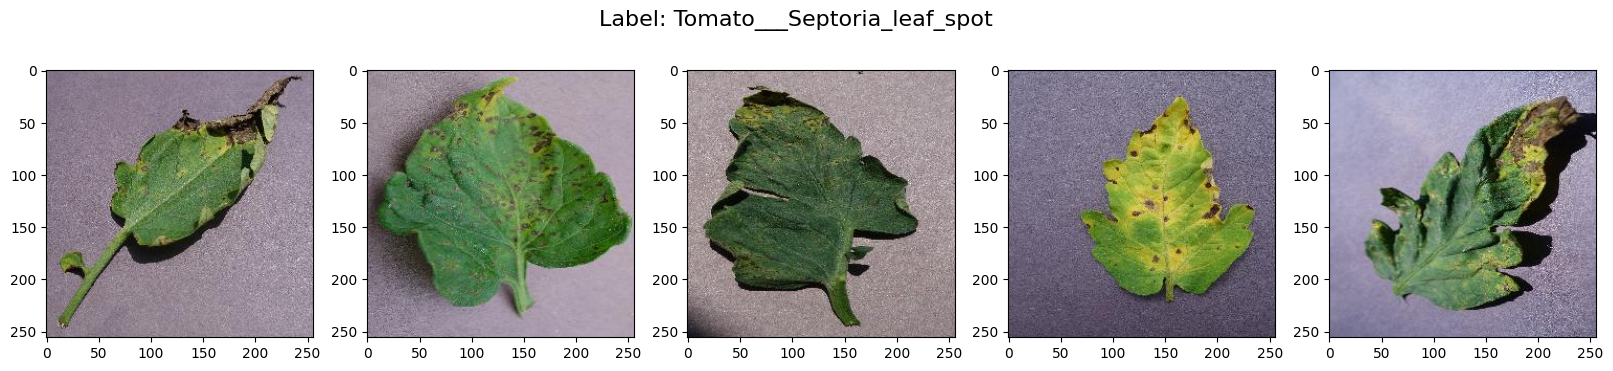

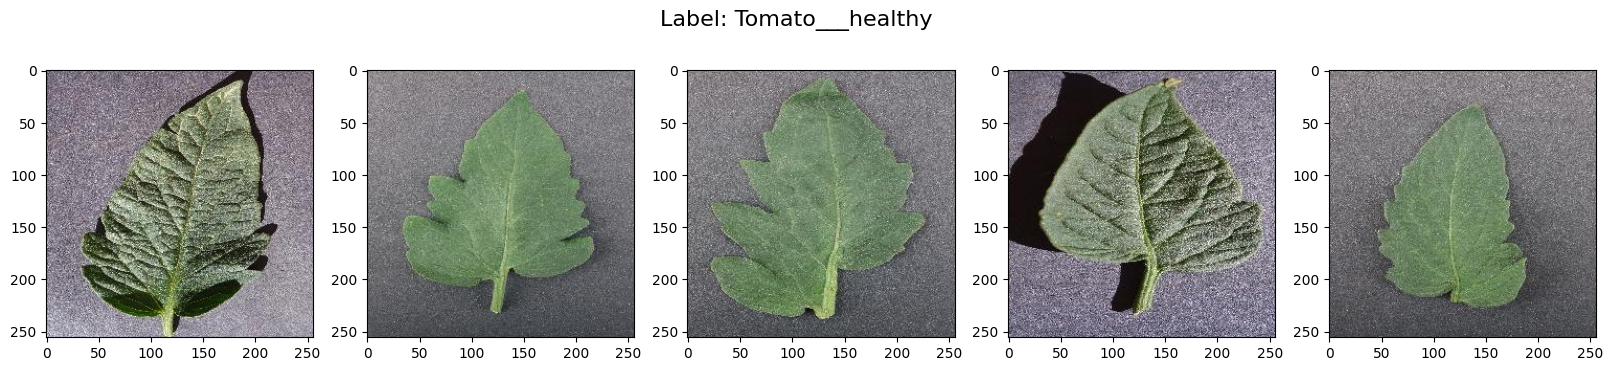

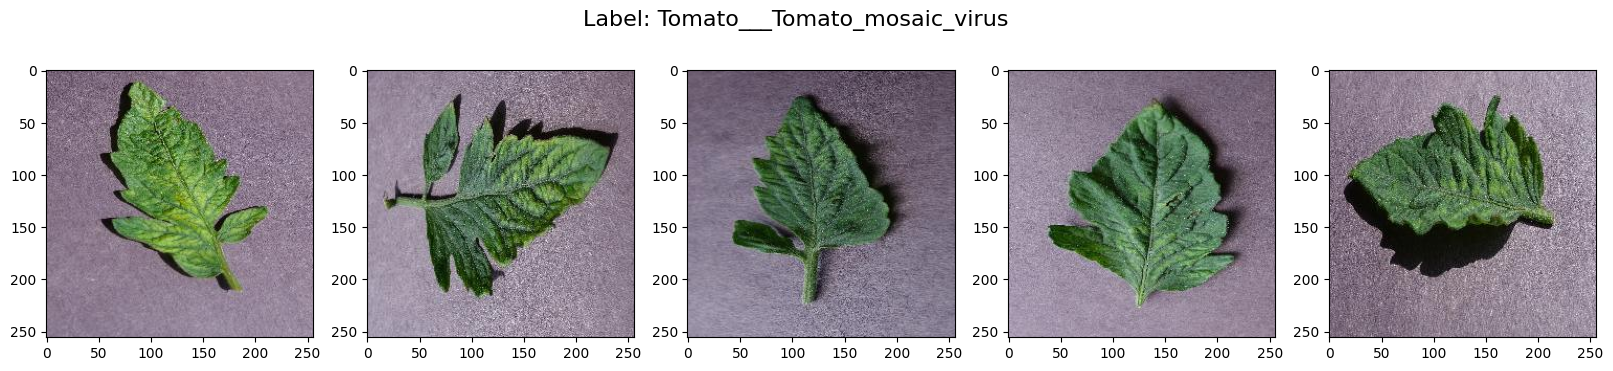

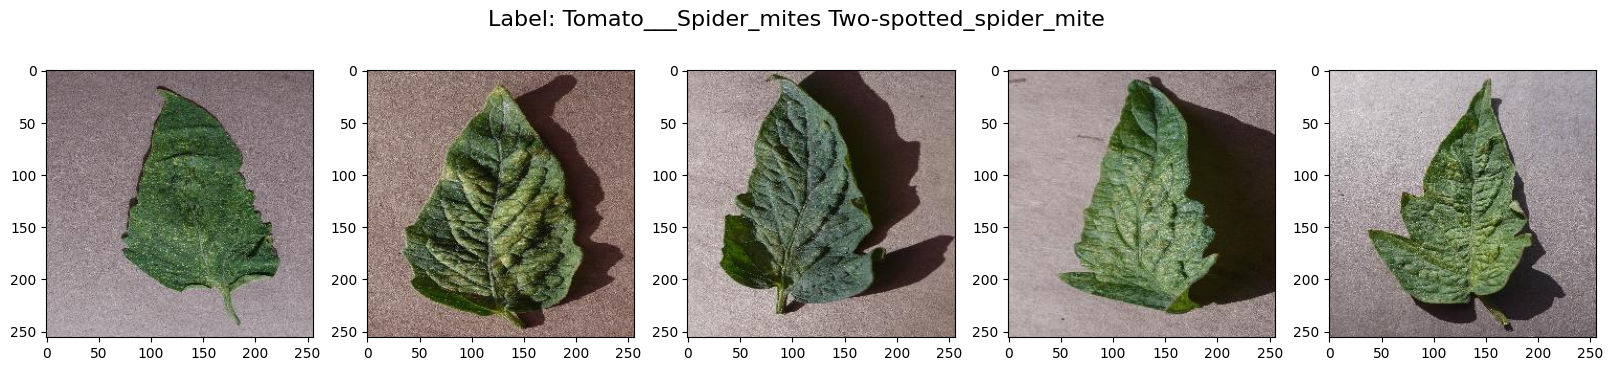

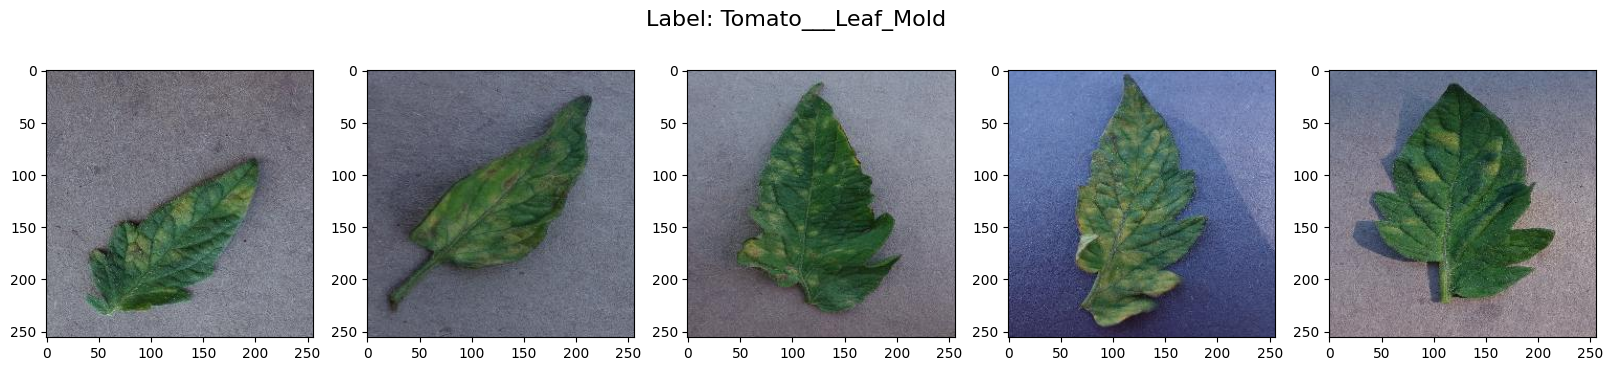

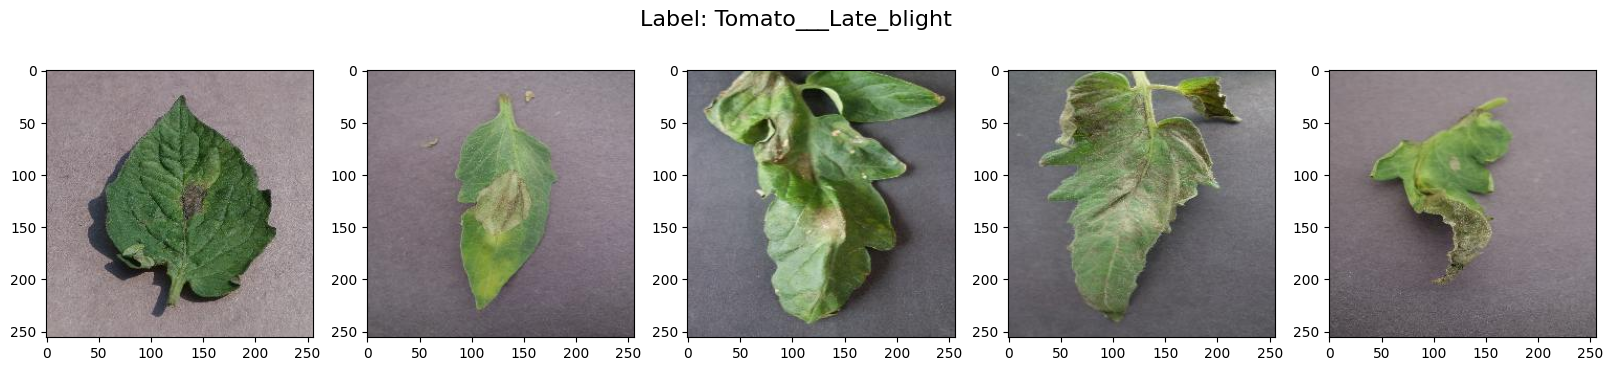

In [28]:
def show_samples(data_dir, class_labels):
    for label in class_labels:
        # Get the path to the class folder
        class_dir = os.path.join(data_dir, label)

        # List all images in the class folder
        class_images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Display the first 5 image
        plt.figure(figsize=(20, 4))  # Set the figure size for each label
        plt.suptitle(f"Label: {label}", fontsize=16)  # Add label title above the row

        for i, img_name in enumerate(class_images[:5]):
            # Load and display the image
            img_path = os.path.join(class_dir, img_name)
            img = mpimg.imread(img_path)

            # Add subplot for each image
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('on')

        # Show the row of images for this label
        plt.show()

# Display samples from the training directory
show_samples(train_dir, class_labels)

# Data Generators

In [36]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.,            # Normalize pixel values
        rotation_range=40,           # Random rotations
        width_shift_range=0.2,       # Random horizontal shifts
        height_shift_range=0.2,      # Random vertical shifts
        shear_range=0.2,             # Shear transformations
        zoom_range=0.2,              # Zoom in and out
        horizontal_flip=True,        # Random horizontal flipping
        fill_mode='nearest',         # Filling strategy for empty pixels
        brightness_range=[0.8, 1.2]  # Adjust brightness
    )

    # Validation data generator without augmentation
    validation_datagen = ImageDataGenerator(rescale=1.0/255.)

    # Generate batches of augmented training data
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        target_size=(150, 150)     # Resizing all images to 150x150
    )

    # Generate batches of validation data
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        class_mode='categorical',
        target_size=(150, 150),
        shuffle=False
    )

    return train_generator, validation_generator

# Initialize generators
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


# Model 1

## CNN Model Architecture

In [37]:
def create_model(num_classes):
    model = tf.keras.models.Sequential([
        # Convolutional Layer 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Convolutional Layer 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Convolutional Layer 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Fully Connected Layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Regularization
        tf.keras.layers.Dense(256, activation='relu'),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
        loss='categorical_crossentropy',  # Loss for multi-class classification
        metrics=['accuracy']
    )

    return model

# Create the model
num_classes = len(class_labels)  # Number of classes (10 for tomato leaf classifier)
model = create_model(num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [38]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.97:  # Stop training if accuracy > 97%
            print("\nReached 97% accuracy. Stopping training!")
            self.model.stop_training = True

# Initialize callback
callbacks = EarlyStoppingCallback()

## Model Training

In [39]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/15
313/313 [==============================] - 75s 235ms/step - loss: 1.7039 - accuracy: 0.3788 - val_loss: 1.5138 - val_accuracy: 0.5210
Epoch 2/15
313/313 [==============================] - 74s 236ms/step - loss: 1.0331 - accuracy: 0.6348 - val_loss: 0.9678 - val_accuracy: 0.6800
Epoch 3/15
313/313 [==============================] - 72s 231ms/step - loss: 0.7841 - accuracy: 0.7199 - val_loss: 0.9660 - val_accuracy: 0.6800
Epoch 4/15
313/313 [==============================] - 74s 236ms/step - loss: 0.6677 - accuracy: 0.7558 - val_loss: 0.8240 - val_accuracy: 0.7500
Epoch 5/15
313/313 [==============================] - 73s 233ms/step - loss: 0.6041 - accuracy: 0.7900 - val_loss: 1.5019 - val_accuracy: 0.6100
Epoch 6/15
313/313 [==============================] - 74s 236ms/step - loss: 0.5393 - accuracy: 0.8091 - val_loss: 0.7266 - val_accuracy: 0.7850
Epoch 7/15
313/313 [==============================] - 72s 231ms/step - loss: 0.5282 - accuracy: 0.8116 - val_loss: 0.5912 - val_ac

## Evaluate the Model

In [40]:
test_datagen = ImageDataGenerator(rescale=1.0/255.)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle=False
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 100 images belonging to 10 classes.
4/4 [==============================] - 0s 28ms/step - loss: 0.2909 - accuracy: 0.8700
Test Accuracy: 87.00%


## Visualize the Result

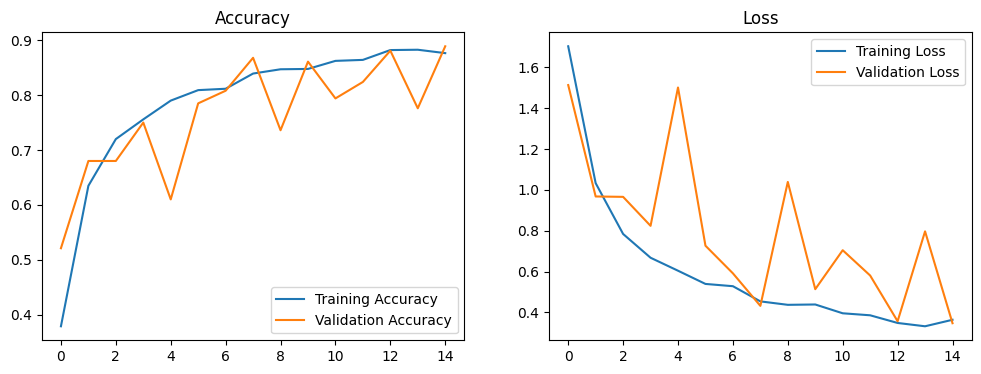

In [41]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Save Model

In [47]:
# Save the model to the specified path
model.save('/content/drive/MyDrive/New_CNN/tomato_leaf_model(CNN)_1.h5')  # Adjust file name as needed
print("Model saved successfully to Google Drive!")

Model saved successfully to Google Drive!


# Model 2 MobileNetV2

## Pretrained Model

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the pretrained MobileNetV2 model
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Freeze the base model layers so they won't be trained
base_model.trainable = False

# Create the new model on top of MobileNetV2
model_2 = Sequential([
    base_model,  # Add the pretrained base model
    GlobalAveragePooling2D(),  # Replace the fully connected layers
    Dense(512, activation='relu'),  # Add a dense layer
    Dropout(0.4),  # Add dropout for regularization
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model_2.compile(
    optimizer='adam',  # Use Adam optimizer for faster convergence
    loss='categorical_crossentropy',  # Loss for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

# Show the model summary
model_2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                         

## Model 2 Training

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train model_2
history_2 = model_2.fit(
    train_generator,
    epochs=30,  # Train for 30 epochs (adjust as needed)
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
313/313 [==============================] - 78s 235ms/step - loss: 1.1601 - accuracy: 0.6051 - val_loss: 0.8900 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 2/30
313/313 [==============================] - 74s 235ms/step - loss: 0.8255 - accuracy: 0.7123 - val_loss: 0.7321 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 3/30
313/313 [==============================] - 74s 237ms/step - loss: 0.7421 - accuracy: 0.7443 - val_loss: 0.6811 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 4/30
313/313 [==============================] - 73s 234ms/step - loss: 0.7183 - accuracy: 0.7489 - val_loss: 0.6349 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 5/30
313/313 [==============================] - 73s 234ms/step - loss: 0.6786 - accuracy: 0.7620 - val_loss: 0.5848 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 6/30
313/313 [==============================] - 72s 230ms/step - loss: 0.6424 - accuracy: 0.7770 - val_loss: 0.5629 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 7/30
313/313 [==============================] 

## Evaluate

In [44]:
# Evaluate the model on the test set
loss, accuracy = model_2.evaluate(test_generator)
print(f"Model 2 Test Accuracy: {accuracy * 100:.2f}%")

4/4 [==============================] - 1s 244ms/step - loss: 0.3855 - accuracy: 0.8600
Model 2 Test Accuracy: 86.00%


## Visualize

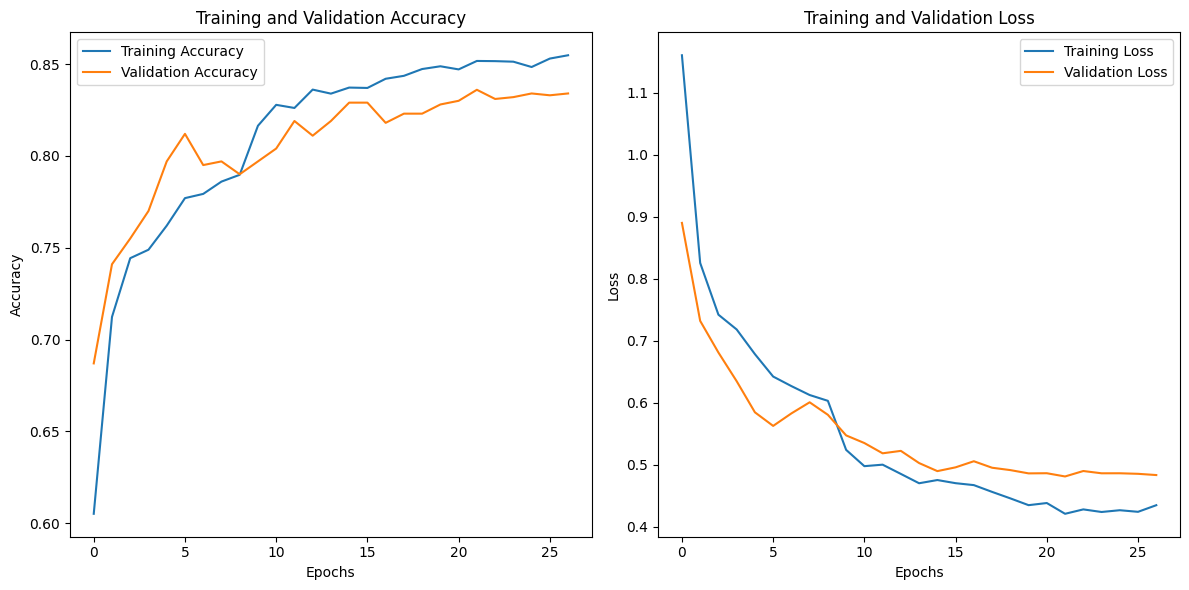

In [45]:
# Get the training history of the model
history_dict = history_2.history  # Assuming you're using history_2 from training

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Save model

In [46]:
# Save the model to the specified path
model_2.save('/content/drive/MyDrive/New_CNN/tomato_leaf_model_2.h5')
print("Model saved successfully to Google Drive!")

Model saved successfully to Google Drive!


# Model 3 DenseNet

In [48]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf

def create_model3(num_labels):
    # Initialize the DenseNet121 model with pre-trained ImageNet weights
    base_model = DenseNet121(
        include_top=False,  # Exclude the fully connected layer
        weights='imagenet',  # Use pre-trained weights
        input_shape=(150, 150, 3)  # Adjust input shape as needed
    )

    # Freeze the base model to avoid updating weights during training
    base_model.trainable = False  # You can fine-tune it later if needed

    # Build the custom model on top of DenseNet121
    model3 = Sequential([
        base_model,  # Pre-trained DenseNet121
        GlobalAveragePooling2D(),  # Global average pooling
        Dropout(0.5),  # Dropout layer to prevent overfitting
        Dense(256, activation='relu'),  # Dense layer with 256 neurons
        Dense(num_labels, activation='softmax')  # Output layer with softmax activation for classification
    ])

    # Compile the model
    model3.compile(
        optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),  # Optimizer with learning rate and momentum
        loss='categorical_crossentropy',  # Loss function for multi-class classification
        metrics=['accuracy']  # Accuracy metric
    )

    return model3

# Assuming `num_labels` is defined based on the number of classes (10 in your case)
num_labels = len(train_class_labels)

# Create the model
model3 = create_model3(num_labels)

# Display the model summary
model3.summary()

29084464/29084464 [==============================] - 0s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 7302474 (27.86 MB)
Trainable params: 264970 (1.01 MB)
Non-trainable params: 7037504 (26.85 MB)
___________

In [49]:
# Define the callback to stop training if accuracy > 98%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.98:
            self.model.stop_training = True
            print("\nThe accuracy of the training set has reached > 98%! Training stopped.")

callbacks = myCallback()

# Train the model
history3 = model3.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/20
313/313 [==============================] - 101s 293ms/step - loss: 1.6700 - accuracy: 0.4269 - val_loss: 1.1239 - val_accuracy: 0.5880
Epoch 2/20
313/313 [==============================] - 82s 261ms/step - loss: 1.3743 - accuracy: 0.5234 - val_loss: 1.0510 - val_accuracy: 0.6400
Epoch 3/20
313/313 [==============================] - 82s 260ms/step - loss: 1.2780 - accuracy: 0.5562 - val_loss: 1.0136 - val_accuracy: 0.6520
Epoch 4/20
313/313 [==============================] - 83s 264ms/step - loss: 1.2404 - accuracy: 0.5735 - val_loss: 0.9045 - val_accuracy: 0.6810
Epoch 5/20
313/313 [==============================] - 83s 265ms/step - loss: 1.2058 - accuracy: 0.5897 - val_loss: 0.9305 - val_accuracy: 0.6720
Epoch 6/20
313/313 [==============================] - 82s 262ms/step - loss: 1.1927 - accuracy: 0.5971 - val_loss: 0.9874 - val_accuracy: 0.6610
Epoch 7/20
313/313 [==============================] - 82s 260ms/step - loss: 1.1589 - accuracy: 0.6006 - val_loss: 0.8746 - val_a

In [50]:
# Evaluate the model on the test set
loss, accuracy = model3.evaluate(test_generator)
print(f"Model 2 Test Accuracy: {accuracy * 100:.2f}%")

4/4 [==============================] - 2s 641ms/step - loss: 0.6841 - accuracy: 0.8200
Model 2 Test Accuracy: 82.00%


## Save model

In [51]:
model3.save('/content/drive/MyDrive/New_CNN/tomato_leaf_model_3.h5')
print("Model 3 saved successfully to Google Drive!")

Model 3 saved successfully to Google Drive!


## Fine-tune

In [ ]:
# Unfreeze the last few layers of the base model for fine-tuning
base_model.trainable = True

# Recompile the model after unfreezing the layers
model3.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),  # Use a smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training the model
history3_fine_tune = model3.fit(
    train_generator,
    epochs=10,  # Additional epochs
    validation_data=validation_generator,
    callbacks=[callbacks],
    verbose=1
)